In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx
from collections import Counter
import itertools
import random as rd
import numpy as np
from scipy.optimize import curve_fit
import collections
import itertools as it
from IPython.display import Image

from networkx.generators.random_graphs import barabasi_albert_graph
import random

## Exercise 7 -- computing the breakdown threshold

Perform random failure simulations (see Tutorial 6) with 

o a Barabasi-Albert networks (#nodes = [100,1000]) and two different numbers of preferentially attached edges

o and with the `protein.edgelist.txt` data set.

    Interprete briefly what you find for the breakdown threshold in both experiments.

o Repeat this experiment for Erdos-Renyi networks but run the simulations 100 times and average over the 
resulting threshold values.

    What is your expectation for this value? Compare it to the numerical result.

(12 pts)

In [3]:
# perform failure simulations
def random_failure(G, number_of_steps = 25):
        
    N = G.number_of_nodes()
    M = N // number_of_steps
    num_nodes_removed = range(0, G.number_of_nodes(), M)
    C = G.copy()
    random_attack_core_proportions = []

    for nodes_removed in num_nodes_removed:
        # Measure the relative size of the network core
        core = next(nx.connected_components(C))
        core_proportion = len(core) / N
        random_attack_core_proportions.append(core_proportion)

        # If there are more than M nodes, select M nodes at random and remove them
        if C.number_of_nodes() > M:
            nodes_to_remove = random.sample(list(C.nodes), M)
            C.remove_nodes_from(nodes_to_remove)
    
    return num_nodes_removed, random_attack_core_proportions


In [4]:
# define Barabasi-Albert graph parameters
n = [100, 1000]
m = [10, 50, 90] 

all_nodes_removed = []
all_random_proportions = []
parameter_pairs = []

# go though every combination
for i in n:
    for j in m:
        
        # define Barabasi-Albert graph
        G = barabasi_albert_graph(i, j)
        parameter_pairs.append([i, j])
        
        num_nodes_removed, random_attack_core_proportions = random_failure(G)
        
        # store results
        all_nodes_removed.append(num_nodes_removed)
        all_random_proportions.append(random_attack_core_proportions)

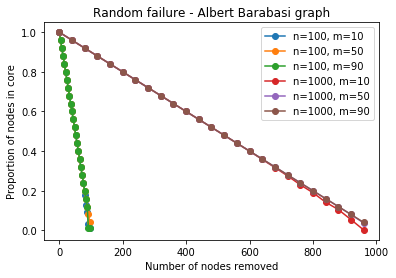

In [5]:
# plot results for each graph
plt.title('Random failure - Albert Barabasi graph')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
for i in range(0, len(parameter_pairs)):
    plt.plot(all_nodes_removed[i], 
             all_random_proportions[i], 
             marker='o', 
             label='n=' + str(parameter_pairs[i][0]) + ', m=' + str(parameter_pairs[i][1]))

plt.legend()
plt.show()

In [12]:
# read 'Protein' graph
path = '../data/'
G = nx.read_edgelist(path + "protein.edgelist.txt")

num_nodes_removed, random_attack_core_proportions = random_failure(G)

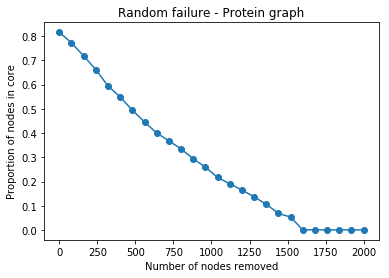

In [13]:
plt.title('Random failure - Protein graph')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

In the Barabasi-Albert graph, we observe that the number of links m is insignificant in this case. Clearly, the breakdown threshold in this case is fc=1,  meaning that when removing randomly nodes in the Barabasi-Albert network, any fraction of nodes will not break the network.
In the 'Protein' network,we observe that the proportion of nodes in the core follows a very similar pattern as the BA graph, as we remove the nodes. 

In [72]:
# function that computes the number of nodes that need to be removed using random failure
# in order to disconnect the largest connected component 

def get_breakdown_threshold(G, number_of_steps = 20):
        
    N = G.number_of_nodes()
    if N == 100:
        number_of_steps = 50
    if N == 1000:
        number_of_steps = 300

    M = N // number_of_steps
    num_nodes_removed = range(0, G.number_of_nodes(), M)
    C = G.copy()
    random_attack_core_proportions = []

    for nodes_removed in num_nodes_removed:
        # Measure the relative size of the network core
        core = next(nx.connected_components(C))
        core_proportion = len(core) / N
        random_attack_core_proportions.append(core_proportion)
        
        # if core proportion has dropped close to 0
        # we can conclude that the lcc is disconnected
        if core_proportion < (1/N):
            return nodes_removed

        # If there are more than M nodes, select M nodes at random and remove them
        if C.number_of_nodes() > M:
            nodes_to_remove = random.sample(list(C.nodes), M)
            C.remove_nodes_from(nodes_to_remove)
    
    return nodes_removed
    

In [73]:
# Erdos-Renyi graphs
# we set the pairs
n = [100, 1000]
m = [2700, 3500, 4400] 

parameter_pairs = []
repetition = 100

# go though every pair element wise
for i in n:
    for j in m:
        
        all_nodes_removed = []
        for r in range(repetition):
            # define Erdos-Renyi graph
            G = nx.gnm_random_graph(i, j)
            parameter_pairs.append([i, j])

            # get number of nodes removed until breakdown
            num_nodes_removed = get_breakdown_threshold(G)

            # store results
            all_nodes_removed.append(num_nodes_removed)

        print('n =', i, 'm =', j)
        mean_nodes_removed = sum(all_nodes_removed) / len(all_nodes_removed)
        print('average nodes removed:', mean_nodes_removed, ' threshold:', mean_nodes_removed/i)

n = 100 m = 2700
average nodes removed: 98.0  threshold: 0.98
n = 100 m = 3500
average nodes removed: 98.0  threshold: 0.98
n = 100 m = 4400
average nodes removed: 98.0  threshold: 0.98
n = 1000 m = 2700
average nodes removed: 999.0  threshold: 0.999
n = 1000 m = 3500
average nodes removed: 999.0  threshold: 0.999
n = 1000 m = 4400
average nodes removed: 999.0  threshold: 0.999


We can see that for n = 100, the threshold is 0.98.
For n = 1000, we can see that the threshold is 0.99. 
It is not dependent on the number of edges for both cases.
As N increases, the threshold gets closer to 1, but we need to make sure the a large number of links so that the largest component in the graph has <k> >= 2. 